In [5]:
from torch import nn
from torch.nn.functional import relu
class ResidualBlock(nn.Module):
    def __init__(self,in_feature_maps,out_feature_maps) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(in_feature_maps,out_feature_maps,kernel_size=8,padding='same',bias=False)
        self.bn1 = nn.LayerNorm((out_feature_maps,5000),elementwise_affine=False)

        self.c2 = nn.Conv1d(out_feature_maps,out_feature_maps,kernel_size=5,padding='same',bias=False)
        self.bn2 = nn.LayerNorm((out_feature_maps,5000),elementwise_affine=False)

        self.c3 = nn.Conv1d(out_feature_maps,out_feature_maps,kernel_size=3,padding='same',bias=False)
        self.bn3 = nn.LayerNorm((out_feature_maps,5000),elementwise_affine=False)

        self.c4 = nn.Conv1d(in_feature_maps,out_feature_maps,1,padding='same',bias=False)
        self.bn4 = nn.LayerNorm((out_feature_maps,5000),elementwise_affine=False)

    def forward(self,x):
        identity = x
        x = self.c1(x)
        x = self.bn1(x)
        x = relu(x)

        x = self.c2(x)
        x = self.bn2(x)
        x = relu(x)

        x = self.c3(x)
        x = self.bn3(x)
        x = relu(x)

        identity = self.c4(identity)
        identity = self.bn4(identity)

        x = x+identity
        x = relu(x)
        
        return x

class ResNet(nn.Module):
    def __init__(self,device='cuda') -> None:
        super().__init__()
        self.block1 = ResidualBlock(1,64).to(device)
        self.block2 = ResidualBlock(64,128).to(device)

        self.gap = nn.AvgPool1d(kernel_size=5000)
        self.fc1 = nn.Linear(in_features=128,out_features=3)
    def forward(self,x):
        x = x.view(-1,1,5000)
        x = self.block1(x)
        x = self.block2(x)
        x = self.gap(x)
        x = self.fc1(x.squeeze())
        return x

In [59]:
device = 'cuda'
model = ResNet().to(device)
from lib.datasets import Dataset2p0
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
params = sum([p.flatten().size()[0] for p in list(model.parameters())])
print("Params: ",params)
data_dir = 'data/w1_balanced_normalized'
trainloader = DataLoader(Dataset2p0(dir=f'{data_dir}/train/',labels=f'{data_dir}/y_train.pt'),batch_size=64,shuffle=True)
devloader = DataLoader(Dataset2p0(dir=f'{data_dir}/test/',labels=f'{data_dir}/y_test.pt'),batch_size=64,shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Params:  238531


In [63]:
lossi = []

In [64]:
import matplotlib.pyplot as plt
model.train()
for (X_tr,y_tr) in tqdm(trainloader):
    X_tr,y_tr = X_tr.to(device),y_tr.to(device)
    logits = model(X_tr)
    loss = criterion(logits,y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

100%|██████████| 5218/5218 [09:24<00:00,  9.25it/s]


tensor(0.3722)


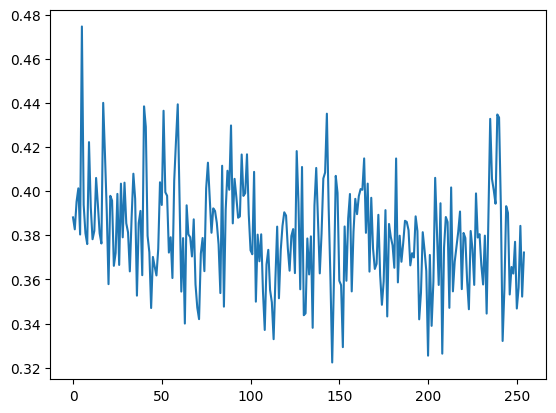

In [66]:
plt.plot(torch.tensor(lossi[100:len(lossi) - len(lossi)%20]).view(-1,20).mean(axis=1))
print(torch.tensor(lossi[100:len(lossi) - len(lossi)%20]).view(-1,20).mean(axis=1)[-1])